# Project: 2DEG mobility calculation using mobilitypy¶

The mobility models are implemented using the following refs:

Ref-1: J. Bassaler, J. Mehta, I. Abid, L. Konczewicz, S. Juillaguet, S. Contreras, S. Rennesson, S. Tamariz, M. Nemoz, F. Semond, J. Pernot, F. Medjdoub, Y. Cordier, P. Ferrandis, Al-Rich AlGaN Channel High Electron Mobility Transistors on Silicon: A Relevant Approach for High Temperature Stability of Electron Mobility. Adv. Electron. Mater. 2024, 2400069. https://doi.org/10.1002/aelm.202400069

Ref-2: Zhang, J., Hao, Y., Zhang, J. et al. The mobility of two-dimensional electron gas in AlGaN/GaN heterostructures with varied Al content. Sci. China Ser. F-Inf. Sci. 51, 780–789 (2008). https://doi.org/10.1007/s11432-008-0056-7

Ref-3: 

# 1. Settings

## 1.1 Import modules

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
from pathlib import Path
#sys.path.insert(0, os.path.join(mobilitypy_tutorial_path, '../'))
from mobilitypy import AlloyParams, Mobility2DCarrier

In [4]:
redo_mobility_cal = True # re-do mobility calculation
resave_mobilities = True # re-save the calculated mobility values. Make sure you use redo_mobility_cal=True.

In [5]:
folder_2deg_data_parent = '/home/Docs5/badal.mondal/linuxhome/MyFolder/Projects/DeviceSimulation/NextnanoSimulations/DATAs/AlGaN_HEMT/AlGaN_AlGaN_AlN_HEMT/nnp/'
folder_2deg_density_file = os.path.join(folder_2deg_data_parent, '2DEHG_density/OneDim', 'sim_post_process_data.xlsx')
folder_2deg_mobility_folder = os.path.join(folder_2deg_data_parent, '2DEHG_mobility/OneDim')
folder_2deg_mobility_file = os.path.join(folder_2deg_mobility_folder,'sim_post_process_data.xlsx') 
Path(folder_2deg_mobility_folder).mkdir(parents=True, exist_ok=True)

## 1.2 Set physical constants

In [6]:
alloy_disordered_effect=1
interface_roughness_effect=1
dislocation_effect=1
deformation_potential_effect=1 
piezoelectric_effect=1
acoustic_phonon_effect=1
polar_optical_phonon_effect=1
total_mobility=1
mobility_model='Bassaler'
#===================================
density_2deg = 0.1 # nm^-2
irf_rms_roughness = 0.3 # nm
irf_corr_length = 3.0 # nm
dislocation_density = 1e-4 # nm^-2
occup_dislocation = 0.3
T_sweep = [10, 100, 200, 300, 400, 500, 600, 700, 800] # in K , sweep temperature
T_corect_bandgap_in_LFOM = False

In [7]:
rescale_2deg_fact=1e13

# 2. Calculate mobilities

## 2.1 Al0.25Ga0.75N(25nm)/GaN(305nm) HEMT LFOM for normalization

### 2.1.1 Read 2DEG data from nextnano simulation

In [8]:
if redo_mobility_cal:
    data_sheet_name =  'GaN_C_sweep__Temperature'
    n_2d_df_ref = pd.read_excel(folder_2deg_density_file, sheet_name=data_sheet_name, index_col=0)
    density_2deg_comp_ref = np.array(n_2d_df_ref['2DEG_device'], dtype=float)/1e+14 # cm^-2 to nm^-2 conversion

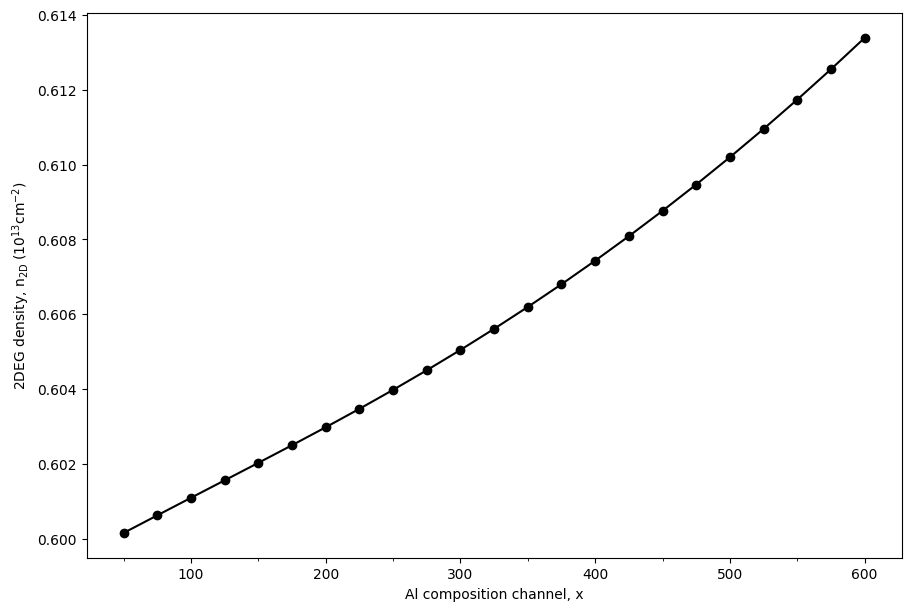

In [9]:
if redo_mobility_cal:
    fig, ax = plt.subplots(figsize=(9,6), constrained_layout=True)
    XX = np.array(n_2d_df_ref['Temperature'], dtype=float)
    ax.plot(XX, n_2d_df_ref['2DEG_device']/rescale_2deg_fact, 'o-', c='k')
    ax.set_xlabel('Al composition channel, x')
    ax.set_ylabel(r'2DEG density, n$_\mathrm{2D}$ ($\mathrm{10}^{13}\mathrm{cm}^{-2}$)')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))

Conclusion: 2DEG density negligible depend on temperature

### 2.1.2 Calculate Al0.25Ga0.75N(25nm)/GaN(305nm) mobilities

In [10]:
if redo_mobility_cal:
    channel_comp_ref = 0 # Channel is pure GaN
    density_2deg_comp_ref = 0.0625 # in nm^-2
    mu2deg = Mobility2DCarrier(compositions=channel_comp_ref, binaries=['AlN', 'GaN'], alloy='AlGaN', system='ternary', 
                               print_log=None, eps_n_2d=1e-10)

In [11]:
if redo_mobility_cal:
    mobility_ref_dff = pd.DataFrame()
    
    for T in T_sweep:
        # Calculate mobilities
        mobility_ref = mu2deg.calculate_sheet_mobility(n_2d=density_2deg_comp_ref, rms_roughness=irf_rms_roughness,
                                                       corr_len=irf_corr_length, n_dis=dislocation_density,
                                                       f_dis=occup_dislocation, T=T,
                                                       alloy_disordered_effect=False,
                                                       interface_roughness_effect=interface_roughness_effect,
                                                       dislocation_effect=dislocation_effect,
                                                       deformation_potential_effect=deformation_potential_effect,
                                                       piezoelectric_effect=piezoelectric_effect,
                                                       acoustic_phonon_effect=acoustic_phonon_effect,
                                                       polar_optical_phonon_effect=polar_optical_phonon_effect,
                                                       total_mobility=total_mobility,
                                                       #calculate_total_mobility_only=True,
                                                       mobility_model=mobility_model)
        
        ref_mu_total = np.array(mobility_ref['TOT'], dtype=float) # cm^2.V^-1.s^-1
        # Add temperature column
        mobility_ref['T'] = T # K
        mobility_ref['2DEG_device'] = density_2deg_comp_ref*1e14 #cm^-2
        # Calculate LFOM
        mobility_ref['LFOM'] = mu2deg.calculate_figure_of_merit(density_2deg_comp_ref, ref_mu_total,
                                                                temp=T, T_corect_bandgap=T_corect_bandgap_in_LFOM) # LFOM: MW/cm^2
        # Calculate sheet resitance
        mobility_ref['R'] = mu2deg.calculate_sheet_resitance(density_2deg_comp_ref, ref_mu_total) #ohm per square
        # Concatenate dataframes
        mobility_ref_dff = pd.concat([mobility_ref_dff, mobility_ref], ignore_index=True)

In [12]:
if resave_mobilities:
    # Create the file if it does not exist
    if not os.path.exists(folder_2deg_mobility_file):
        with pd.ExcelWriter(folder_2deg_mobility_file, engine='openpyxl', mode="w") as writer:  
            mobility_ref_dff.to_excel(writer, sheet_name='ref_Al25Ga75N_GaN')
    else:
        with pd.ExcelWriter(folder_2deg_mobility_file, engine='openpyxl', mode="a", if_sheet_exists="replace") as writer:  
            mobility_ref_dff.to_excel(writer, sheet_name='ref_Al25Ga75N_GaN')

## 2.3 AlGaN/AlGaN mobilities and figure-of-merit

### 2.3.1 Read 2DEG data from nextnano simulation

In [13]:
if redo_mobility_cal:
    data_sheet_name =  'sim_sweep__AlContentBarrier__AlContentChannel__ThicknessAlGaNBarrier'
    n_2d_df = pd.read_excel(folder_2deg_density_file, sheet_name=data_sheet_name, index_col=0)
    density_2deg_comp = np.array(n_2d_df['2DEG_device'], dtype=float)/1e+14 # cm^-2 to nm^-2 conversion
    channel_comp = np.array(n_2d_df['AlContentChannel'], dtype=float)

### 2.3.2 Calculate mobilities

In [14]:
if redo_mobility_cal:
    mu2deg = Mobility2DCarrier(compositions=channel_comp, binaries=['AlN', 'GaN'], alloy='AlGaN', system='ternary')

In [15]:
if redo_mobility_cal:
    mobility_dff = pd.DataFrame()
    
    for T in T_sweep:
        # Calculate mobilities
        mobility_df = mu2deg.calculate_sheet_mobility(n_2d=density_2deg_comp, rms_roughness=irf_rms_roughness, 
                                                      corr_len=irf_corr_length, n_dis=dislocation_density, 
                                                      f_dis=occup_dislocation, T=T,
                                                      alloy_disordered_effect=alloy_disordered_effect,
                                                      interface_roughness_effect=interface_roughness_effect,
                                                      dislocation_effect=dislocation_effect,
                                                      deformation_potential_effect=deformation_potential_effect,
                                                      piezoelectric_effect=piezoelectric_effect,
                                                      acoustic_phonon_effect=acoustic_phonon_effect,
                                                      polar_optical_phonon_effect=polar_optical_phonon_effect,
                                                      total_mobility=total_mobility,
                                                      mobility_model=mobility_model)
        mu_total = np.array(mobility_df['TOT'], dtype=float) # cm^2.V^-1.s^-1
        # Add temperature column
        mobility_df['T'] = T # K
        # Calculate LFOM
        mobility_df['LFOM'] = mu2deg.calculate_figure_of_merit(density_2deg_comp, mu_total, 
                                                               temp=T, T_corect_bandgap=T_corect_bandgap_in_LFOM) # LFOM: MW/cm^2
        mobility_df['LFOM_2DEG1e13'] = mu2deg.calculate_figure_of_merit(0.1, mu_total, temp=T, 
                                                                        T_corect_bandgap=T_corect_bandgap_in_LFOM) # LFOM: MW/cm^2
        # Calculate sheet resitance
        mobility_df['R'] = mu2deg.calculate_sheet_resitance(density_2deg_comp, mu_total) #ohm per square
        # Concatenate dataframes
        Combined_dff = pd.concat([n_2d_df, mobility_df], axis=1)
        mobility_dff = pd.concat([mobility_dff, Combined_dff], ignore_index=True)

In [65]:
if resave_mobilities:
    with pd.ExcelWriter(folder_2deg_mobility_file, engine='openpyxl', mode="a", if_sheet_exists="replace") as writer:  
        mobility_dff.to_excel(writer, sheet_name='AlGaN_AlGaN')